In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import ast

In [2]:
sm = pd.read_csv('/Users/josephking/Documents/sponsored_projects/MERGEN/data/vehicle_classifier/data_directories/Bboxes_sm.csv')
xl = pd.read_csv('../data/Bboxes.csv')

sm['Bboxes'] = sm['Bboxes'].apply(lambda x: list(ast.literal_eval(x)))
xl['Bboxes'] = xl['Bboxes'].apply(lambda x: list(ast.literal_eval(x)))

#### Original length of both datasets

In [3]:
print(len(sm))
print(len(xl))

690014
690014


#### Drop rows with no vehicle

Note - small YOLOv5 used 50% threshold, whereas XL imposed no minimum threshold

In [4]:
sm = sm.loc[sm.Bboxes.str.len() != 0].reset_index(drop=True)  # restrict to rows with bounding boxes
xl = xl.loc[xl.Bboxes.str.len() != 0].reset_index(drop=True)  # restrict to rows with bounding boxes

In [5]:
print(len(sm))
print(len(xl))

531559
656294


#### Column for confidence

In [6]:
sm['conf'] = sm['Bboxes'].apply(lambda x: x[-1])
xl['conf'] = xl['Bboxes'].apply(lambda x: x[-1])

In [7]:
sm['conf']

0         0.745485
1         0.677161
2         0.690799
3         0.776664
4         0.839136
            ...   
531554    0.623437
531555    0.751536
531556    0.858630
531557    0.723038
531558    0.866400
Name: conf, Length: 531559, dtype: float64

#### Among XL with >= 50%

In [8]:
print("total valid rows >= 50% confidence:", len(xl.loc[xl['conf'] >= 0.5]))
print("percent more rows than small acc'd 50% thresh:", round((632523-531559)/531559, 4))

total valid rows >= 50% confidence: 632523
percent more rows than small acc'd 50% thresh: 0.1899


#### Compare distributions

In [9]:
sm['conf'].describe()

count    531559.000000
mean          0.687458
std           0.106434
min           0.500000
25%           0.599155
50%           0.686028
75%           0.771753
max           0.937059
Name: conf, dtype: float64

In [10]:
xl['conf'].describe()

count    656294.000000
mean          0.825433
std           0.129141
min           0.250244
25%           0.788574
50%           0.871582
75%           0.912109
max           0.962891
Name: conf, dtype: float64

In [11]:
xl.loc[xl['conf'] >= 0.5]['conf'].describe()

count    632523.000000
mean          0.841892
std           0.098002
min           0.500000
25%           0.801758
50%           0.875488
75%           0.913574
max           0.962891
Name: conf, dtype: float64

#### Kernel density plot

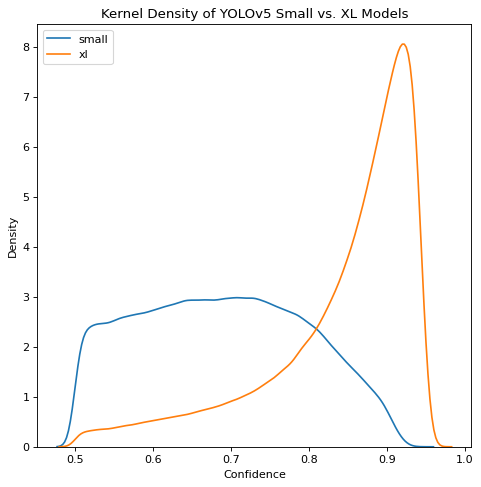

In [12]:
figure(figsize=(7, 7), dpi=80)
sns.kdeplot(sm['conf'], label='small')
sns.kdeplot(xl.loc[xl['conf'] >= 0.5]['conf'], label='xl')
plt.legend()
plt.xlabel('Confidence')
plt.title('Kernel Density of YOLOv5 Small vs. XL Models')
plt.savefig('../yolov5_small_xl.png', dpi=80)
plt.show()

In [13]:
len(sm)

531559

In [14]:
len(xl.loc[xl['conf'] >= 0.871582])

329093

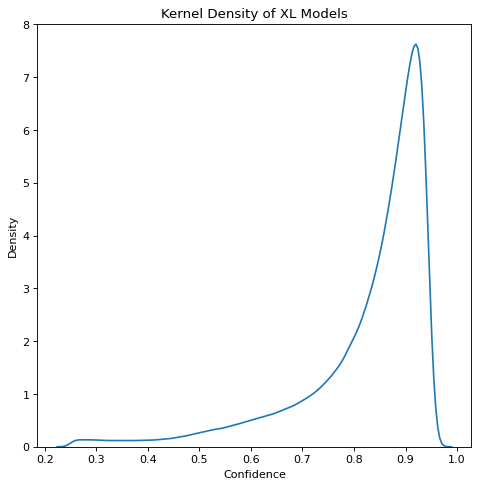

In [15]:
figure(figsize=(7, 7), dpi=80)
sns.kdeplot(xl['conf'])
plt.xlabel('Confidence')
plt.title('Kernel Density of XL Models')
plt.show()